In [37]:
from hydradx.model.processing import import_binance_prices
from hydradx.model.amm.global_state import GlobalState, OmnipoolState, historical_prices
from hydradx.model.amm.global_state import liquidate_against_omnipool_and_settle_otc

from hydradx.model.amm.agents import Agent
from hydradx.model.amm.trade_strategies import omnipool_arbitrage, back_and_forth, invest_all
from hydradx.model.amm.omnipool_amm import dynamicadd_lrna_fee, dynamicadd_asset_fee
from hydradx.model import run
from hydradx.model.amm.money_market import MoneyMarket, CDP
from hydradx.model.amm.global_state import update_prices_and_process

import matplotlib.pyplot as plt




# Simulation 1: Historic BTC price crash

In [57]:
price_list = import_binance_prices(['BTC', 'ETH', 'DOT', 'USDC'], start_date='May 1 2024', days=30)
# price_list = price_list[2000:3000]
# print(price_list)
price_list_padded = []
for x in price_list:
    prices_padded = {'BTC': x['BTC'], 'ETH': x['ETH'], 'DOT': x['DOT'], 'USDC': x['USDC'], 'HDX': 0.015, 'USDT': 1}
    price_list_padded.append(prices_padded)

KeyboardInterrupt: 

In [58]:
price_list = import_binance_prices(['USDC'], start_date='May 1 2024', days=30)
# price_list = price_list[2000:3000]
# print(price_list)
usdc_prices = [x['USDC'] for x in price_list]
print(min(usdc_prices))
print(max(usdc_prices))



0.9992
1.0017


In [39]:


assets = {
    'HDX': {'usd price': price_list_padded[0]['HDX'], 'weight': 0.05},
    'USDT': {'usd price': 1, 'weight': 0.10},
    'USDC': {'usd price': price_list_padded[0]['USDC'], 'weight': 0.10},
    'BTC': {'usd price': price_list_padded[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list_padded[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list_padded[0]['DOT'], 'weight': 0.40},
}

lrna_price_usd = 38
initial_omnipool_tvl = 25000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd
    
omnipool = OmnipoolState(
        tokens={
            tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
        },
        # oracles={'fee_raise': 50},
        # lrna_fee=dynamicadd_lrna_fee(
        #     minimum=0.0005,
        #     amplification=1,
        #     raise_oracle_name='fee_raise',
        #     decay=0.00001,
        #     fee_max=0.1,
        # ),
        lrna_fee=0.0005,
        # asset_fee=dynamicadd_asset_fee(
        #     minimum=0.0025,
        #     amplification=1,
        #     raise_oracle_name='fee_raise',
        #     decay=0.00005,
        #     fee_max=0.4,
        # ),
        asset_fee=0.0025,
        preferred_stablecoin='USDT',
    )

init_omnipool_state = omnipool.copy()

init_ltv = {'BTC': .79, 'ETH': .79, 'DOT': .74, 'USDC': .89, 'USDT': .89}
pct_of_omnipool = 1
cdps = []
cdp_ct = 1
arb_freq = 10
# for tkn in ['BTC', 'ETH', 'DOT', 'USDT']:
#     collat = pct_of_omnipool * omnipool.liquidity[tkn] / cdp_ct
#     debt = collat * price_list_padded[0][tkn] * init_ltv[tkn]
#     for i in range(cdp_ct):
#         cdp_init = CDP('USDT', tkn, debt, collat)
#         cdps.append(cdp_init)
collat = pct_of_omnipool * omnipool.liquidity["USDT"] / cdp_ct
debt = collat * price_list_padded[0]["USDT"] * init_ltv["USDT"]
for i in range(cdp_ct):
    cdp_init = CDP('USDT', "USDC", debt, collat)
    cdps.append(cdp_init)
mm = MoneyMarket(
    liquidity={"USDT": 1000000, "BTC": 1000, "ETH": 10000, "DOT": 100000, "USDC": 1000000},
    oracles={
        ("BTC", "USDT"): price_list_padded[0]['BTC'],
        ("ETH", "USDT"): price_list_padded[0]['ETH'],
        ("DOT", "USDT"): price_list_padded[0]['DOT'],
        ("USDC", "USDT"): price_list_padded[0]['USDT']
    },
    liquidation_threshold={'BTC': .8, 'ETH': .8, 'DOT': .75, 'USDC': .9, 'USDT': .9},
    full_liquidation_threshold={'BTC': .8/.95, 'ETH': .8/.95, 'DOT': .75/.95, 'USDC': .9/.95, 'USDT': .9/.95},
    partial_liquidation_pct=0.5,
    cdps=cdps,
    liquidation_penalty={'BTC': .05, 'ETH': .05, 'DOT': .07, 'USDC': .03, 'USDT': .03},
)

init_money_market = mm.copy()

# price_transform = historical_prices(price_list_padded)
# liquidate_transform = liquidate_against_omnipool_and_settle_otc('omnipool', 'Arbitrageur')
# def compound_transform(state: GlobalState) -> GlobalState:
#     return liquidate_transform(price_transform(state))

initial_state = GlobalState(
    pools={'omnipool': omnipool},
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USDT': 1000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'ETH': 1000000000, 'BTC': 1000000000,
                      'USDC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                frequency=arb_freq
            )
        ),
    },
    evolve_function=update_prices_and_process('omnipool', 'Arbitrageur', price_list_padded, "USDT", 0.005),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    money_market=mm,
)

init_global_state = initial_state.copy()

time_steps = len(price_list)-1
print(cdp_init)

CDP(USDT, USDC, 2225000.0, 2500000.0)


In [40]:
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
print(len(events))

Running with 999 time steps
Starting simulation...
Execution time: 0.426 seconds.
999


In [41]:
ltv_data = {'USDC': []}
max_ltv_data = {'USDC': []}
for event in events:
    for tkn in ['USDC']:
        tkn_cdps = event.money_market.get_cdps(collateral_tkn=tkn)
        ltv_list = [cdp.debt_amt / cdp.collateral_amt / event.external_market[tkn] for cdp in tkn_cdps]
        average_ltv = sum(ltv_list) / len(tkn_cdps)
        max_ltv_data[tkn].append(max(ltv_list))
        ltv_data[tkn].append(average_ltv)
print([ltv_data[tkn][-1] for tkn in ['USDC']])
max_ltv = {'USDC': None}
for tkn in ['USDC']:
    max_ltv[tkn] = max(ltv_data[tkn])
print(max_ltv)

[0.8888445021472086]
{'USDC': 0.8891997202517735}


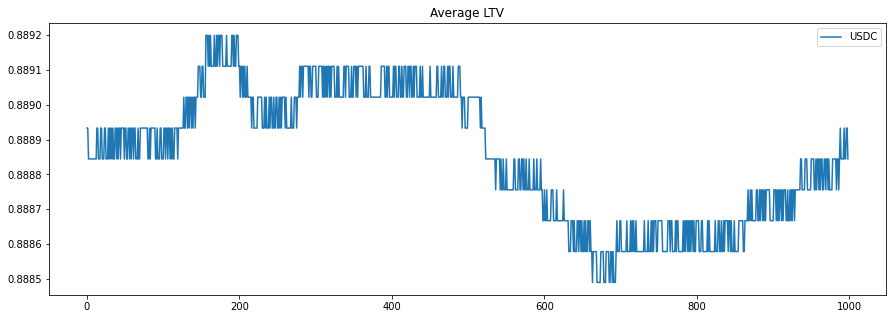

In [42]:
plt.figure(figsize=(15, 5))
for tkn in ['USDC']:
    plt.plot(ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Average LTV')
plt.show()

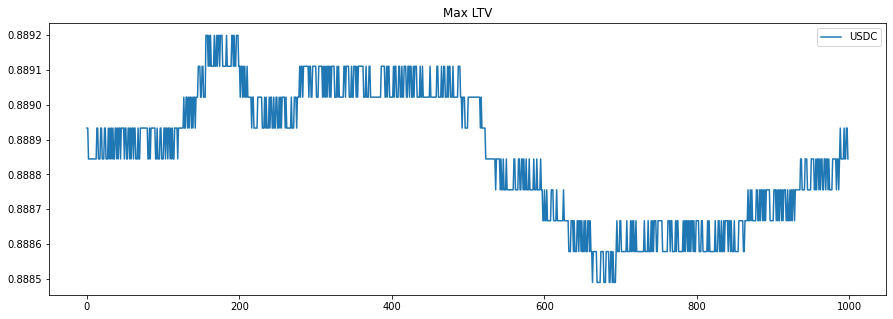

In [43]:
plt.figure(figsize=(15, 5))
for tkn in ['USDC']:
    plt.plot(max_ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Max LTV')
plt.show()

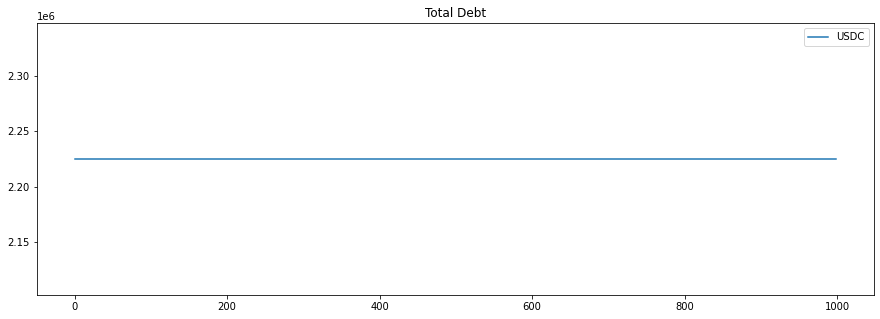

In [44]:
plt.figure(figsize=(15, 5))
for tkn in ['USDC']:
    tkn_debt = []
    for event in events:
        tkn_debt.append(sum([cdp.debt_amt for cdp in event.money_market.get_cdps(collateral_tkn=tkn)]))
    # tkn_debt = [event.money_market.get_cdps(collateral_tkn=tkn)[0][1].debt_amt for event in events]
    plt.plot(tkn_debt, label=tkn)
plt.legend()
plt.title('Total Debt')
plt.show()

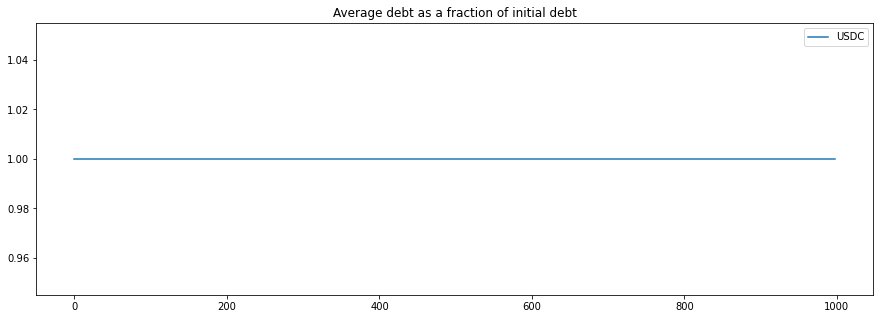

In [45]:
plt.figure(figsize=(15, 5))
total_debt_data = {'USDC': []}
init_debt_data = [cdp.debt_amt for cdp in events[0].money_market.cdps]
for event in events:
    total_tkn_debt = {tkn: 0 for tkn in ['USDC']}
    total_cdp_ct = {tkn: 0 for tkn in ['USDC']}
    for i in range(len(event.money_market.cdps)):
        cdp = event.money_market.cdps[i]
        total_tkn_debt[cdp.collateral_asset] += cdp.debt_amt / init_debt_data[i] if init_debt_data[i] > 0 else 0
        total_cdp_ct[cdp.collateral_asset] += 1
    for tkn in ['USDC']:
        total_debt_data[tkn].append(total_tkn_debt[tkn] / total_cdp_ct[tkn])
for tkn in ['USDC']:
    plt.plot(total_debt_data[tkn], label=tkn)
plt.legend()
plt.title('Average debt as a fraction of initial debt')
plt.show()

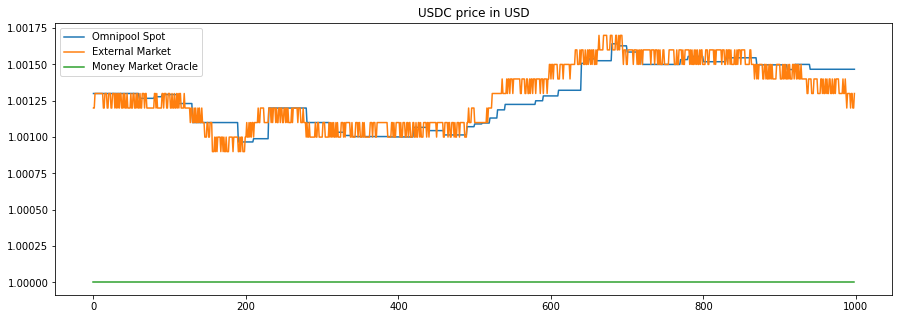

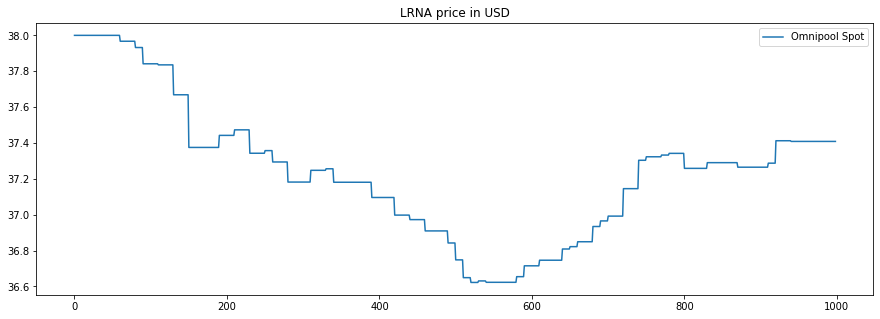

In [46]:
for tkn in ['USDC', 'LRNA']:
    plt.figure(figsize=(15, 5))
    plt.plot([event.pools['omnipool'].price(event.pools['omnipool'], tkn, 'USDT') for event in events], label='Omnipool Spot')
    if tkn != 'LRNA':
        plt.plot([event.external_market[tkn] for event in events], label='External Market')
        plt.plot([event.money_market.oracles[(tkn, 'USDT')] for event in events], label='Money Market Oracle')
    plt.title(f'{tkn} price in USD')
    plt.legend()
    plt.show()

# Creating synthetic price data for simulation 2

1000
[59808.0, 59770.0, 59757.95, 59746.0, 59790.0]
[57183.99, 57177.48, 57165.01, 57151.1, 57124.99]


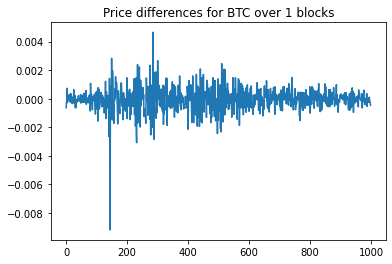

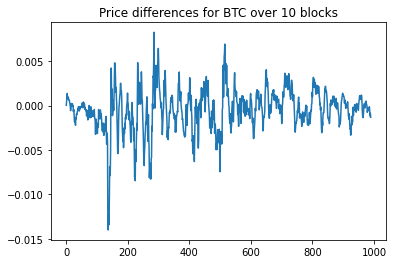

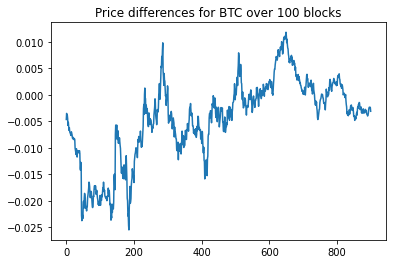

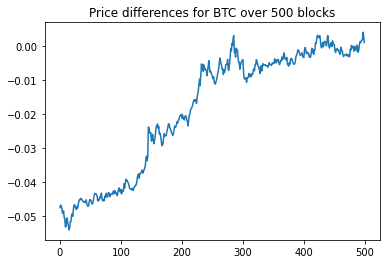

{1: -0.009185748320479489, 10: -0.013995644078194211, 100: -0.02552901023890785, 500: -0.05396023069765941}
{1: 0.004658517792098571, 10: 0.008265445502941966, 100: 0.011846284251345122, 500: 0.00418484938020389}
{1: -0.009185748320479489, 10: -0.001399564407819421, 100: -0.0002552901023890785, 500: -0.00010792046139531881}
{1: 0.004658517792098571, 10: 0.0008265445502941965, 100: 0.00011846284251345122, 500: 8.36969876040778e-06}


In [47]:
btc_prices = [prices['BTC'] for prices in price_list_padded]
print(len(btc_prices))
print(btc_prices[0:5])
print(btc_prices[-5:])
price_diffs = {}

for b_ct in [1,10,100,500]:
    price_diffs[b_ct] = [(btc_prices[i+b_ct] - btc_prices[i])/btc_prices[i] for i in range(len(btc_prices)-b_ct)]
    plt.plot(price_diffs[b_ct])
    plt.title(f'Price differences for BTC over {b_ct} blocks')
    plt.show()
    
biggest_drop = {}
biggest_spike = {}
for b_ct in [1,10,100,500]:
    biggest_drop[b_ct] = min(price_diffs[b_ct])
    biggest_spike[b_ct] = max(price_diffs[b_ct])

print(biggest_drop)
print(biggest_spike)


print({b_ct: biggest_drop[b_ct]/b_ct for b_ct in biggest_drop})
print({b_ct: biggest_spike[b_ct]/b_ct for b_ct in biggest_spike})


1000
[59808.0, 59770.0, 59757.95, 59746.0, 59790.0]
[57183.99, 57177.48, 57165.01, 57151.1, 57124.99]


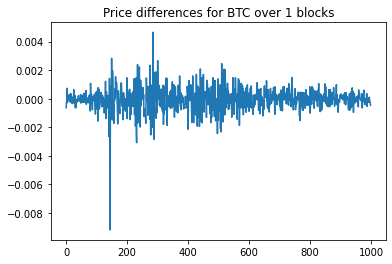

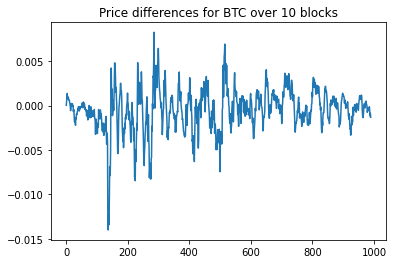

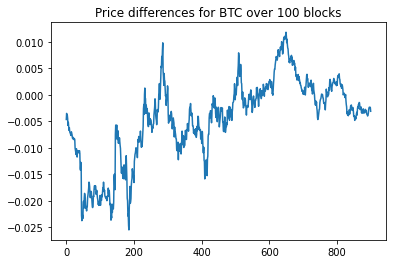

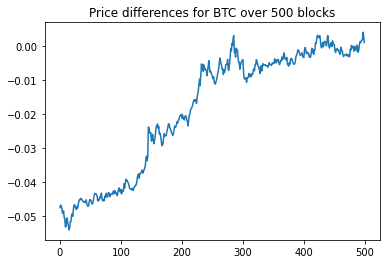

{1: -0.009185748320479489, 10: -0.013995644078194211, 100: -0.02552901023890785, 500: -0.05396023069765941}
{1: 0.004658517792098571, 10: 0.008265445502941966, 100: 0.011846284251345122, 500: 0.00418484938020389}
{1: -0.009185748320479489, 10: -0.001399564407819421, 100: -0.0002552901023890785, 500: -0.00010792046139531881}
{1: 0.004658517792098571, 10: 0.0008265445502941965, 100: 0.00011846284251345122, 500: 8.36969876040778e-06}
1000
[2974.49, 2972.4, 2971.3, 2971.0, 2973.27]
[2877.29, 2876.46, 2877.38, 2876.47, 2875.8]


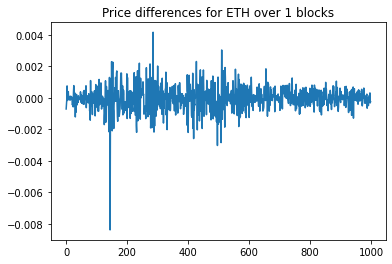

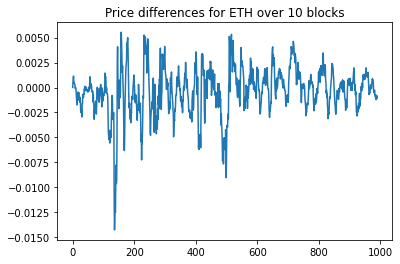

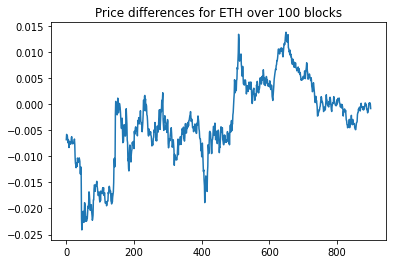

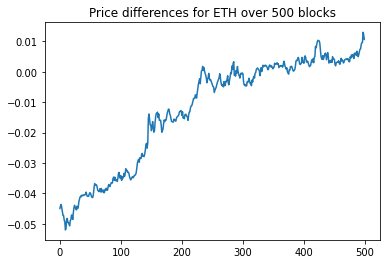

{1: -0.00838723580378246, 10: -0.014259423352191294, 100: -0.024110775958054144, 500: -0.05202201370982119}
{1: 0.004174776550220849, 10: 0.0055329474421766415, 100: 0.013743724507182904, 500: 0.013019293057315877}
{1: -0.00838723580378246, 10: -0.0014259423352191293, 100: -0.00024110775958054143, 500: -0.00010404402741964237}
{1: 0.004174776550220849, 10: 0.0005532947442176641, 100: 0.00013743724507182903, 500: 2.6038586114631754e-05}
1000
[6.503, 6.497, 6.494, 6.497, 6.502]
[6.417, 6.416, 6.419, 6.407, 6.408]


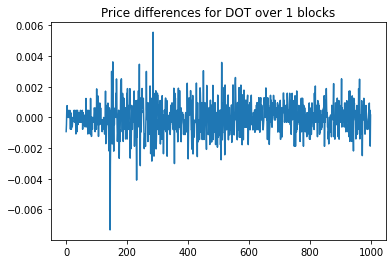

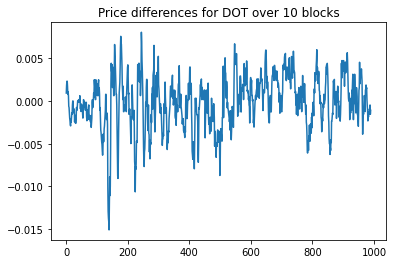

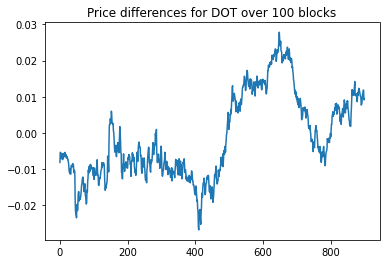

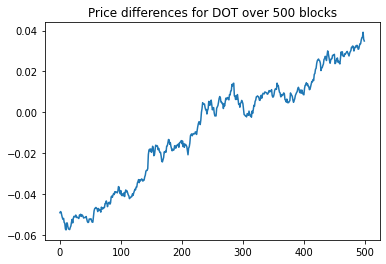

{1: -0.007333437353721284, 10: -0.015092578185778674, 100: -0.026808375634517843, 500: -0.057458903057305354}
{1: 0.005553792446842295, 10: 0.008044164037854915, 100: 0.02782245094885816, 500: 0.039177594301440834}
{1: -0.007333437353721284, 10: -0.0015092578185778673, 100: -0.00026808375634517845, 500: -0.0001149178061146107}
{1: 0.005553792446842295, 10: 0.0008044164037854914, 100: 0.0002782245094885816, 500: 7.835518860288166e-05}


In [48]:
biggest_drop_dict = {'BTC': 0, 'ETH': 0, 'DOT': 0}
biggest_spike_dict = {'BTC': 0, 'ETH': 0, 'DOT': 0}

for tkn in ['BTC', 'ETH', 'DOT']:
    
    tkn_prices = [prices[tkn] for prices in price_list_padded]
    print(len(tkn_prices))
    print(tkn_prices[0:5])
    print(tkn_prices[-5:])
    price_diffs = {}
    
    for b_ct in [1,10,100,500]:
        price_diffs[b_ct] = [(tkn_prices[i+b_ct] - tkn_prices[i])/tkn_prices[i] for i in range(len(tkn_prices)-b_ct)]
        plt.plot(price_diffs[b_ct])
        plt.title(f'Price differences for {tkn} over {b_ct} blocks')
        plt.show()
        
    biggest_drop = {}
    biggest_spike = {}
    for b_ct in [1,10,100,500]:
        biggest_drop[b_ct] = min(price_diffs[b_ct])
        biggest_spike[b_ct] = max(price_diffs[b_ct])
    
    print(biggest_drop)
    print(biggest_spike)
    
    drop_per_block = {b_ct: biggest_drop[b_ct]/b_ct for b_ct in biggest_drop}
    spike_per_block = {b_ct: biggest_spike[b_ct]/b_ct for b_ct in biggest_spike}
    biggest_drop_dict[tkn] = drop_per_block
    biggest_spike_dict[tkn] = spike_per_block
    print(drop_per_block)
    print({b_ct: biggest_spike[b_ct]/b_ct for b_ct in biggest_spike})


In [49]:
biggest_drop_dict_10 = {tkn: biggest_drop_dict[tkn][10] for tkn in biggest_drop_dict}
print(biggest_drop_dict_10)
biggest_spike_dict_10 = {tkn: biggest_spike_dict[tkn][10] for tkn in biggest_spike_dict}
print(biggest_spike_dict_10)

{'BTC': -0.001399564407819421, 'ETH': -0.0014259423352191293, 'DOT': -0.0015092578185778673}
{'BTC': 0.0008265445502941965, 'ETH': 0.0005532947442176641, 'DOT': 0.0008044164037854914}


In [50]:
from pprint import pprint
pprint(biggest_drop_dict_10)

price_dict_synthetic = {'BTC': [], 'ETH': [], 'DOT': []}
sim_block_ct = 2000
for tkn in ['BTC', 'ETH', 'DOT']:
    price_dict_synthetic[tkn].append(price_list[0][tkn])
    for i in range(1, sim_block_ct):
        if i % 10 == 0:
            price_dict_synthetic[tkn].append(price_dict_synthetic[tkn][-1] * (1 + biggest_drop_dict_10[tkn]))
        else:
            price_dict_synthetic[tkn].append(price_dict_synthetic[tkn][-1])
            
# pprint(price_list_synthetic[0:20])
pprint({tkn: price_dict_synthetic[tkn][-1] for tkn in ['BTC', 'ETH', 'DOT']})

price_list_synthetic = [{tkn: price_dict_synthetic[tkn][i] for tkn in ['BTC', 'ETH', 'DOT']} for i in range(len(price_dict_synthetic['BTC']))]
for d in price_list_synthetic:
    d['HDX'] = 0.015
pprint(price_list_synthetic[8:12])
    

{'BTC': -0.001399564407819421,
 'DOT': -0.0015092578185778673,
 'ETH': -0.0014259423352191293}
{'BTC': 45260.33461787107, 'DOT': 4.814799615661414, 'ETH': 2239.1751557045104}
[{'BTC': 59808.0, 'DOT': 6.503, 'ETH': 2974.49, 'HDX': 0.015},
 {'BTC': 59808.0, 'DOT': 6.503, 'ETH': 2974.49, 'HDX': 0.015},
 {'BTC': 59724.29485189714,
  'DOT': 6.493185296405788,
  'ETH': 2970.248548783314,
  'HDX': 0.015},
 {'BTC': 59724.29485189714,
  'DOT': 6.493185296405788,
  'ETH': 2970.248548783314,
  'HDX': 0.015}]


# Simulation 2: Synthetic severe BTC price crash

In [51]:


assets = {
    'HDX': {'usd price': price_list_synthetic[0]['HDX'], 'weight': 0.05},
    'USDT': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list_synthetic[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list_synthetic[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list_synthetic[0]['DOT'], 'weight': 0.40},
}

liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd
    
omnipool = OmnipoolState(
        tokens={
            tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
        },
        lrna_fee=0.0005,
        asset_fee=0.0025,
        preferred_stablecoin='USDT',
    )

init_ltv = {'BTC': .79, 'ETH': .79, 'DOT': .74, 'USDC': .94}
pct_of_omnipool = 1
cdps = []
cdp_ct = 100
for tkn in ['BTC', 'ETH', 'DOT']:
    collat = pct_of_omnipool * omnipool.liquidity[tkn] / cdp_ct
    debt = collat * price_list_synthetic[0][tkn] * init_ltv[tkn]
    for i in range(cdp_ct):
        cdp_init = CDP('USDT', tkn, debt, collat)
        cdps.append(cdp_init)
mm = MoneyMarket(
    liquidity={"USDT": 1000000, "BTC": 1000, "ETH": 10000, "DOT": 100000},
    oracles={
        ("BTC", "USDT"): price_list_synthetic[0]['BTC'],
        ("ETH", "USDT"): price_list_synthetic[0]['ETH'],
        ("DOT", "USDT"): price_list_synthetic[0]['DOT'],
    },
    liquidation_threshold={'BTC': .8, 'ETH': .8, 'DOT': .75, 'USDT': .9},
    full_liquidation_threshold={'BTC': .8/.95, 'ETH': .8/.95, 'DOT': .75/.95, 'USDT': .9/.95},
    partial_liquidation_pct=0.5,
    cdps=cdps,
    liquidation_penalty={'BTC': .05, 'ETH': .05, 'DOT': .07, 'USDT': .03},
)

init_money_market = mm.copy()


initial_state = GlobalState(
    pools={'omnipool': omnipool},
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USDT': 1000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'ETH': 1000000000, 'BTC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                frequency=arb_freq
            )
        ),
    },
    evolve_function=update_prices_and_process('omnipool', 'Arbitrageur', price_list_synthetic, "USDT", 0.005),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    money_market=mm,
)

init_global_state = initial_state.copy()

time_steps = len(price_list_synthetic)-1
print(cdp_init)

CDP(USDT, DOT, 74000.0, 15377.518068583731)


In [52]:
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
print(len(events))

Running with 1999 time steps
Starting simulation...
Execution time: 21.099 seconds.
1999


In [53]:
ltv_data = {'BTC': [], 'ETH': [], 'DOT': []}
max_ltv_data = {'BTC': [], 'ETH': [], 'DOT': []}
for event in events:
    for tkn in ['BTC', 'ETH', 'DOT']:
        tkn_cdps = event.money_market.get_cdps(collateral_tkn=tkn)
        ltv_list = [(cdp.debt_amt / cdp.collateral_amt / event.external_market[tkn] if cdp.collateral_amt > 0 else 2) for cdp in tkn_cdps ]
        average_ltv = sum(ltv_list) / len(tkn_cdps)
        max_ltv = max(ltv_list)
        ltv_data[tkn].append(average_ltv)
        max_ltv_data[tkn].append(max_ltv)
print([ltv_data[tkn][-1] for tkn in ['BTC', 'ETH', 'DOT']])
max_ltv = {'BTC': None, 'ETH': None, 'DOT': None}
for tkn in ['BTC', 'ETH', 'DOT']:
    max_ltv[tkn] = max(ltv_data[tkn])
print(max_ltv)

[0.5841617463644428, 0.6223384768793451, 0.6263942993894924]
{'BTC': 0.8023025532285226, 'ETH': 0.8036159975333698, 'DOT': 0.752397340737886}


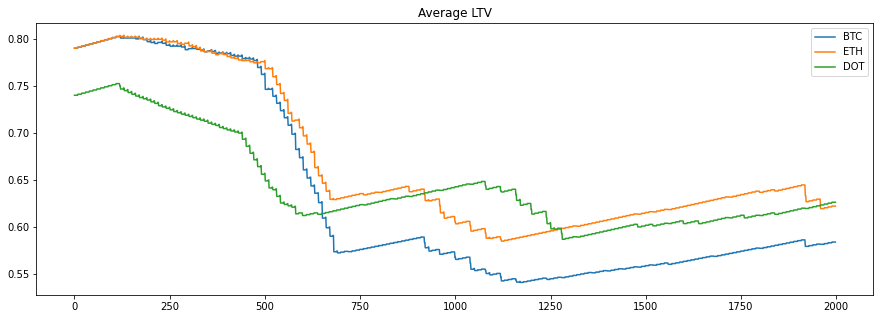

In [54]:
plt.figure(figsize=(15, 5))
for tkn in ['BTC', 'ETH', 'DOT']:
    plt.plot(ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Average LTV')
plt.show()

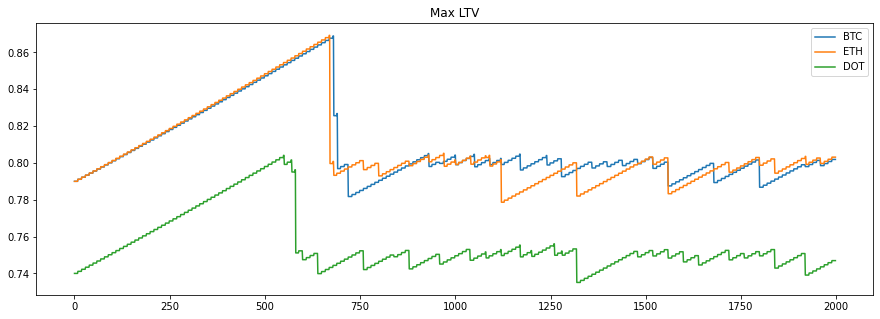

In [55]:
plt.figure(figsize=(15, 5))
for tkn in ['BTC', 'ETH', 'DOT']:
    plt.plot(max_ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Max LTV')
plt.show()

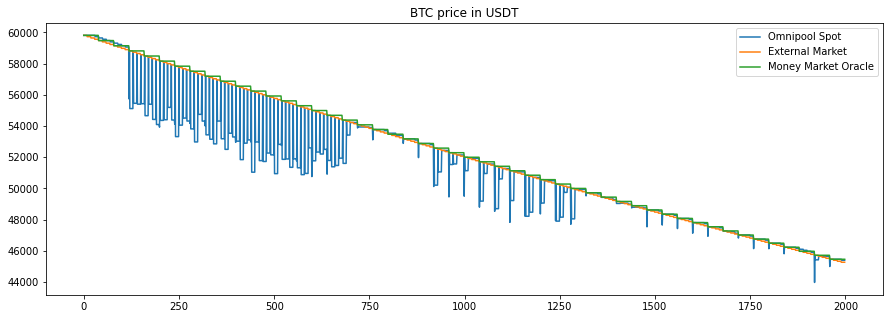

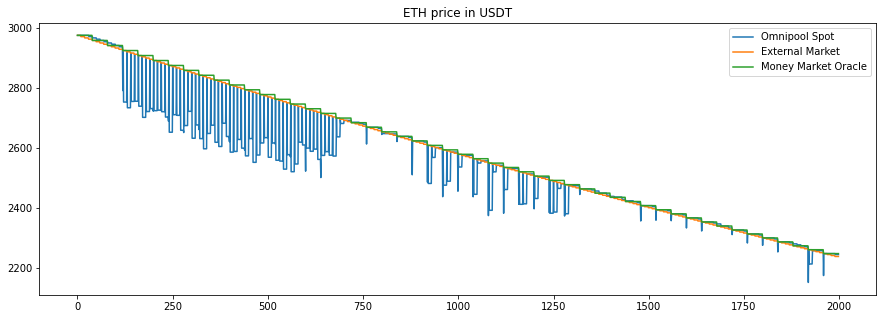

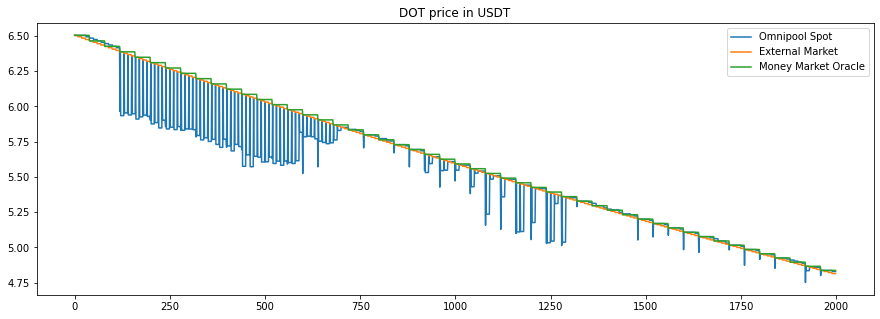

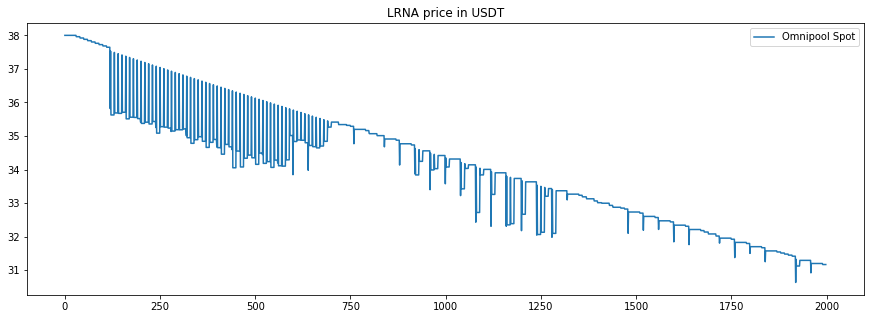

In [56]:
for tkn in ['BTC', 'ETH', 'DOT', 'LRNA']:
    plt.figure(figsize=(15, 5))
    plt.plot([event.pools['omnipool'].price(event.pools['omnipool'], tkn, 'USDT') for event in events], label='Omnipool Spot')
    if tkn != 'LRNA':
        plt.plot([event.external_market[tkn] for event in events], label='External Market')
        plt.plot([event.money_market.oracles[(tkn, 'USDT')] for event in events], label='Money Market Oracle')
    plt.title(f'{tkn} price in USDT')
    plt.legend()
    plt.show()